In [168]:
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
from sklearn.cluster import DBSCAN
from dotenv import load_dotenv
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from libary.Database import Database

In [169]:
# Modelo Preditivo de IPTU
database = Database(schema='pesquisa', table='view_leituras_sensores', ambiente = 0)

In [170]:
df = database.select_table()

In [171]:
df.head(5)

id  id_sensor  id_unidade  id_direcao_saida  id_estado  id_area  \
0   0        246           3                 2          3        2   
1   1        246           4                 1          3        2   
2   2        245           4                 1          3        2   
3   3        245           3                 2          3        2   
4   4        245           3                 2          3        2   

        sensor     periodo  valor unidade       direcao_saida  estado  \
0  PZ-BM-BV-54  2013-09-28  24.57       m   Cota Piezométrica  normal   
1  PZ-BM-BV-54  2013-09-28   0.00   m.c.a  Carga Piezométrica  normal   
2  PZ-BM-BV-53  2013-10-07   0.00   m.c.a  Carga Piezométrica  normal   
3  PZ-BM-BV-53  2013-10-07  27.74       m   Cota Piezométrica  normal   
4  PZ-BM-BV-53  2013-10-09  27.74       m   Cota Piezométrica  normal   

       area  latitude  longitude  altura  \
0  Dique 6C -3.146614 -51.790474   22.40   
1  Dique 6C -3.146614 -51.790474   22.40   
2  Dique 6C -3.146830 -51.789863   24.57   
3  Dique 6C -3.146830 -51.789863   24.57   
4  Dique 6C -3.146830 -51.789863   24.57   

                                                geom  
0  01010000A0E610000070E9FE3D2EE549C0F35E6F31442C...  
1  01010000A0E610000070E9FE3D2EE549C0F35E6F31442C...  
2  01010000A0E61000003AA7603B1AE549C019697049B52C...  
3  01010000A0E61000003AA7603B1AE549C019697049B52C...  
4  01010000A0E61000003AA7603B1AE549C019697049B52C...

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46171 entries, 0 to 46170
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                46171 non-null  int64  
 1   id_sensor         46171 non-null  int64  
 2   id_unidade        46171 non-null  int64  
 3   id_direcao_saida  46171 non-null  int64  
 4   id_estado         46171 non-null  int64  
 5   id_area           46171 non-null  int64  
 6   sensor            46171 non-null  object 
 7   periodo           46171 non-null  object 
 8   valor             46171 non-null  float64
 9   unidade           46171 non-null  object 
 10  direcao_saida     46171 non-null  object 
 11  estado            46171 non-null  object 
 12  area              46171 non-null  object 
 13  latitude          46171 non-null  float64
 14  longitude         46171 non-null  float64
 15  altura            46171 non-null  float64
 16  geom              46171 non-null  object

In [173]:
select = ['id_area', 'id_unidade', 'id_direcao_saida', 'id_estado'] #  id, id_sensor removido

In [174]:
scaler = StandardScaler() 
scaler.fit(df_aux[select])
X_scale = scaler.transform(df_aux[select])
df_scale = pd.DataFrame(data=X_scale, columns=df_aux.columns) 
df_scale = round(df_scale, 6)

Text(0, 0.5, 'Inertia')

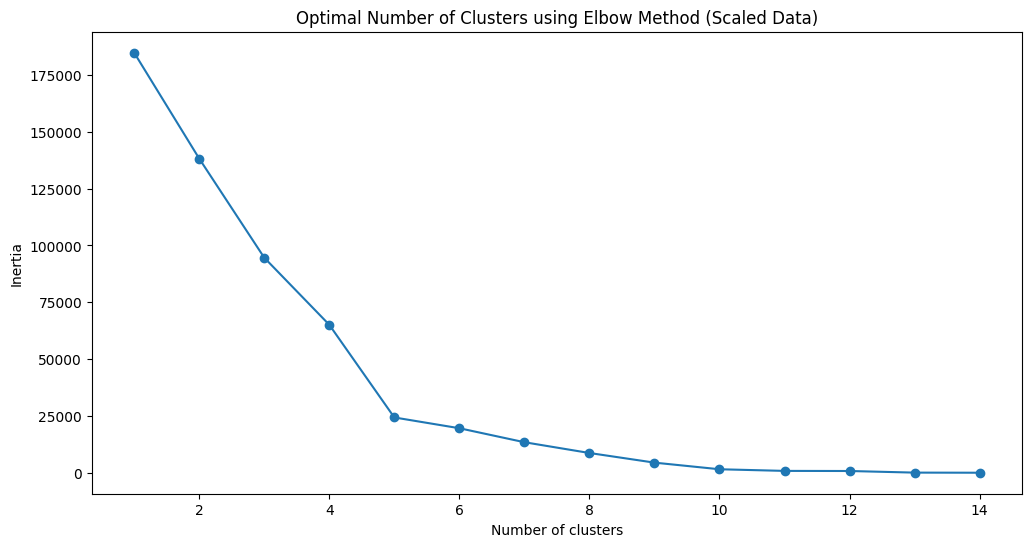

In [175]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(df_scale[select])
    sse.append([k, km.inertia_])
    
oca_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [176]:
kmeans_df_scale = KMeans(n_clusters=5, n_init="auto", init='k-means++', random_state=42).fit(df_scale)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_scale, kmeans_df_scale.labels_, metric='euclidean')))
kmeans_df_scale = kmeans_df_scale.labels_
df = pd.concat([df, pd.DataFrame({'kmean':kmeans_df_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.7380341715680371


In [177]:
df['kmean'].nunique()

5

In [178]:
df.groupby(by=['kmean']).count()[['id_unidade']]

id_unidade
kmean            
0           19549
1            5860
2             344
3           17506
4            2912

In [179]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = clusters_scale['kmean']
trace = go.Scatter3d(x=df.iloc[:,13], y=df.iloc[:,14], z=df.iloc[:,15], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [194]:
model = DBSCAN(eps=0.5, min_samples=1000)
yhat = model.fit_predict(df[select])
df['dbscan'] = yhat

In [195]:
df['dbscan'].nunique()

11

In [196]:
clusters_scale.groupby(by=['dbscan']).count()[['id_unidade']].sort_values(by=['id_unidade'], ascending=False)

id_unidade
dbscan            
 0           10035
 1            9514
 5            8715
 6            8715
 7            1530
 8            1530
 9            1530
 2            1382
 3            1382
 4            1382
-1             456

In [197]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = df['dbscan']
trace = go.Scatter3d(x=df.iloc[:,13], y=df.iloc[:,14], z=df.iloc[:,15], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [184]:
rdsefgtredtgyedr5

NameError: name 'rdsefgtredtgyedr5' is not defined

In [ ]:
print(f"Importando do arquivo .env: {load_dotenv(dotenv_path=r'../.env')}")

In [ ]:
#https://www.youtube.com/watch?v=MEEVcpnfElY
leituras_dique6c = pd.read_csv('../arquivos/leituras_dique6c.csv')
leituras_bvsa = pd.read_csv('../arquivos/leituras_bvsa.csv')

In [ ]:
loc_bvsa = pd.read_csv('../arquivos/loc_bvsa.csv', sep=';', decimal=',')
loc_dique6c = pd.read_csv('../arquivos/loc_dique6c.csv', sep=';', decimal=',')

In [ ]:
loc_sensores = pd.read_excel('../arquivos/LOCALIZAÇÃO_SENSORES.xlsx', engine='openpyxl', header=2)

In [ ]:
leituras_bvsa['area'] = 'BVSA'
leituras_bvsa['area'] = 'Dique 6C'

In [ ]:
leituras = pd.concat([leituras_bvsa, leituras_dique6c])
leituras = leituras.rename(columns={"Sensor":"sensor", "Data":"data", "Valor":"valor", "Unidade":"unidade", "Direcao_Saida":"direcao_saida", "Estado":"estado"})
leituras['direcao_saida'] = leituras['direcao_saida'].replace('Cota NA', 'Cota do NA')

In [ ]:
leituras_bvsa['Sensor'] = leituras_bvsa['Sensor'].apply(lambda x: x.replace("(I)", '').replace("(S)", '').strip())
leituras_dique6c['Sensor'] = leituras_dique6c['Sensor'].apply(lambda x: x.replace("(I)", '').replace("(S)", '').strip())
loc_bvsa['Sensor'] = loc_bvsa['Sensor'].apply(lambda x: x.replace("(I)", '').replace("(S)", '').strip())
loc_dique6c['Sensor'] = loc_dique6c['Sensor'].apply(lambda x: x.replace("(I)", '').replace("(S)", '').strip())

In [ ]:
leituras[leituras['direcao_saida'] == 'Cota do NA']['valor'].mean()

In [ ]:
leituras['direcao_saida'].value_counts()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#leituras['id_sensor'] = le.fit_transform(leituras['sensor'])
leituras['id_unidade'] = le.fit_transform(leituras['unidade']) +1
leituras['id_direcao_saida'] = le.fit_transform(leituras['direcao_saida']) +1
leituras['id_estado'] = le.fit_transform(leituras['estado']) +1
leituras['id_area'] = le.fit_transform(leituras['area']) + 1

leituras = leituras.reset_index(drop=True)

In [ ]:
#Criação da tabela de sensores

In [ ]:
aux = pd.concat([leituras_bvsa[['Sensor']], leituras_dique6c[['Sensor']], loc_bvsa[['Sensor']], loc_dique6c[['Sensor']]])
tabela_sensores = aux.drop_duplicates().sort_values(by=['Sensor']).reset_index(drop=True)
tabela_sensores['Sensor'] = tabela_sensores['Sensor'].apply(lambda x: x.replace("‐", '-').strip())
tabela_sensores.index = tabela_sensores.index+1

In [ ]:
tabela_sensores.to_excel('../tabelas/sensores.xlsx')

In [ ]:
dict_sensores = tabela_sensores.reset_index()[['Sensor','index']].to_dict(orient = 'tight')
dict_sensores = dict(dict_sensores['data']);

In [ ]:
leituras['id_sensor'] = leituras['sensor'].map(dict_sensores) +1

In [ ]:
leituras = leituras[['id_sensor','id_unidade', 'id_direcao_saida', 'id_estado', 'id_area', 'sensor', 'data', 'valor', 'unidade', 'direcao_saida', 'estado', 'area']]

In [ ]:
sensores = pd.DataFrame(tabela_sensores)
sensores = sensores.rename(columns={"Sensor":"name"})
sensores

In [ ]:
#Criação da Tabela de Unidade

In [ ]:
tabela_unidades = pd.concat([leituras_bvsa['Unidade'], leituras_dique6c['Unidade']])
tabela_unidades = tabela_unidades.drop_duplicates().sort_values().reset_index(drop=True)
unidades = pd.DataFrame(tabela_unidades)
unidades = unidades.rename(columns={"Unidade":"name"})
unidades

In [ ]:
#Tabela de Direcao Saida

In [ ]:
tabela_direcao_saida = pd.concat([leituras_bvsa['Direcao_Saida'], leituras_dique6c['Direcao_Saida']])
tabela_direcao_saida = tabela_direcao_saida.drop_duplicates().sort_values().reset_index(drop=True)
direcao_saida = pd.DataFrame(tabela_direcao_saida)
direcao_saida = direcao_saida.rename(columns={"Direcao_Saida":"name"})
direcao_saida

In [ ]:
# Tabela de Estado
leituras['estado'].value_counts()

In [ ]:
# Leituras duplicadas
#leituras[leituras.duplicated(keep=False)]
leituras = leituras.drop_duplicates()

In [ ]:
#Tratamento dos dados de localização
import geopandas as gpd

In [ ]:
localizacao = gpd.GeoDataFrame(pd.concat([loc_bvsa, loc_dique6c]))
localizacao = localizacao.rename(columns={"Sensor":"sensor", "Latitude":"latitude", "Longitude":"longitude", "Altura":"altura"})

In [ ]:
localizacao['sensor'] = localizacao['sensor'].apply(lambda x: x.replace("‐", '-').strip())

In [ ]:
localizacao['id_sensor'] = localizacao['sensor'].map(dict_sensores)

In [ ]:
localizacao

In [ ]:
x_latitude = localizacao['latitude']
y_longitude = localizacao['longitude']
z_altura = localizacao['altura']

In [ ]:
localizacao['geom'] = gpd.GeoSeries.from_xy(x =x_latitude, y=y_longitude, z=z_altura)

In [ ]:
localizacao = localizacao[['id_sensor', 'sensor', 'latitude', 'longitude', 'altura', 'geom']]

In [ ]:
localizacao.head()

In [ ]:
import sqlite3
con = sqlite3.connect("../database.db")

In [ ]:
cur = con.cursor()

In [ ]:
cur.execute("CREATE TABLE if not exists sensores(id INTEGER PRIMARY KEY AUTOINCREMENT, name text)");
cur.execute("CREATE TABLE if not exists unidades(id INTEGER PRIMARY KEY AUTOINCREMENT, name text)");
cur.execute("CREATE TABLE if not exists direcao_saida(id INTEGER PRIMARY KEY AUTOINCREMENT, name text)");
cur.execute("CREATE TABLE if not exists localizacao(id_sensor integer, sensor text, latitude float, longitude float, altura float, geom)");
cur.execute("CREATE TABLE if not exists leituras(id_sensor integer, id_unidade integer, id_direcao_saida integer, id_estado integer, id_area integer, sensor text, data date, valor float, unidade text, direcao_saida text, estado text, area text)");

In [ ]:
localizacao_ = localizacao[['id_sensor', 'sensor', 'latitude', 'longitude', 'altura']]

In [ ]:
sensores.to_sql('sensores', con=con, if_exists='replace', index=False)
unidades.to_sql('unidades', con=con, if_exists='replace', index=False)
direcao_saida.to_sql('direcao_saida', con=con, if_exists='replace', index=False)
localizacao_.to_sql('localizacao', con=con, if_exists='replace', index=False)
leituras.to_sql('leituras', con=con, if_exists='replace', index=False)

In [ ]:
# Não há dados de localização dos densores da tabela de leituras
a = leituras['sensor'].drop_duplicates().to_list() + localizacao['sensor'].drop_duplicates().to_list()
pd.DataFrame(a).value_counts();

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
leituras[['unidade', 'direcao_saida']].value_counts()

In [ ]:
#Sensor indicado sob orinetação Prof. Adam
leituras[leituras['sensor'] == 'PZ-BM-BV-52']['estado'].value_counts()

In [ ]:
leituras.head()

In [ ]:
profile = ProfileReport(leituras, title="leituras")
profile

In [ ]:
profile = ProfileReport(localizacao_, title="Localização")
profile

In [ ]:
query = '''
select l.id_sensor, id_unidade, id_direcao_saida, id_area, id_estado, l.sensor, strftime('%m', "data") AS "month", data, valor, unidade, direcao_saida, estado, latitude, longitude, altura, l.area
from leituras l
left join localizacao l2 on l.id_sensor = l2.id_sensor
where l2.id_sensor is not null and "data" >= '2016-02-01'
order by l.sensor
'''

In [ ]:
df = pd.read_sql(query, con=con)

In [ ]:
df.shape

In [ ]:
df = df[df['sensor'] != 'MNA-BM-BV-51']
df = df[df['sensor'] != 'PZ-D06C-17A']
df = df[df['sensor'] != 'PZ-D06C-18A']
df = df[df['sensor'] != 'MV-BM-BV-02']
df = df[df['sensor'] != 'MNA-AEF1-02']
df = df[df['sensor'] != 'PA-D06C-21']

In [ ]:
x_longitude = df['longitude']
y_latitude = df['latitude']
z_altura = df['altura']
df['geom'] = gpd.GeoSeries.from_xy(x = x_longitude, y=y_latitude)#, z=z_altura)

In [ ]:
gdf = gpd.GeoDataFrame(df, crs="4326", geometry="geom")

In [ ]:
import seaborn as sns
import plotly.graph_objs as go

In [ ]:
df_graph = df[['sensor', 'unidade', 'direcao_saida', 'latitude', 'longitude', 'estado', 'id_estado']].drop_duplicates()

In [ ]:
df_graph

In [ ]:
df['size'] = df['id_estado'].apply(lambda x: 20 if x == 3 else ( 50 if x == 2 else 100))

In [ ]:
leituras['direcao_saida'].value_counts()

In [ ]:
df_graph = df[['sensor', 'unidade', 'direcao_saida', 'estado', 'latitude', 'longitude', 'size']]

In [ ]:
import plotly.express as px
fig = px.scatter(df_graph, x="latitude", y="longitude", color="estado", size='size', hover_data=['size'], symbol="estado")
fig.show()

In [ ]:
#gdf.to_file('shape.geojson')

In [ ]:
df[['unidade', 'direcao_saida']].value_counts()

In [ ]:
df.sort_values(by=['data'], inplace=True)

In [ ]:
#Todos os sensores, em diferentes escalas
fig = px.line(df, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
aux = df[df['unidade'] == 'm']
aux = aux[aux['direcao_saida'] == 'Cota do NA']
df = df.drop(index=aux.index)

In [ ]:
df[df['direcao_saida'] == 'Vazão']['unidade'].value_counts()

In [ ]:
df[['unidade', 'direcao_saida']].value_counts()

In [ ]:
#craiação das categorias de dataframe

In [ ]:
df_m_cota_piezometrica = df[df['direcao_saida'] == 'Cota Piezométrica']
df_m_cota_piezometrica = df_m_cota_piezometrica[df_m_cota_piezometrica['unidade'] == 'm']

print(f'df_m_cota_piezometrica {df_m_cota_piezometrica.shape}')

fig = px.line(df_m_cota_piezometrica, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
X = df_m_cota_piezometrica[['id_unidade', 'id_direcao_saida', 'id_area', 'month', 'latitude', 'longitude', 'altura', 'valor']]

In [ ]:
from sklearn.ensemble import IsolationForest
Iforest = IsolationForest(max_samples=100, 
                          random_state=1111,
                         contamination=0.05,
                         max_features=1.0,
                         n_estimators=100,
                         verbose=1,
                         n_jobs=-1)
Iforest.fit(X)

In [ ]:
df_m_cota_piezometrica = df[df['direcao_saida'] == 'Cota Piezométrica']
df_m_cota_piezometrica = df_m_cota_piezometrica[df_m_cota_piezometrica['unidade'] == 'm']

print(f'df_m_cota_piezometrica {df_m_cota_piezometrica.shape}')

fig = px.line(df_m_cota_piezometrica, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
y_pred = Iforest.predict(X)
df_m_cota_piezometrica['y_pred'] = y_pred

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_m_cota_piezometrica[df_m_cota_piezometrica['y_pred']==1]['data'].values, y=df_m_cota_piezometrica[df_m_cota_piezometrica['y_pred']==1]['valor'].values, mode='markers', name='Não Anomalia'))

fig.add_trace(go.Scatter(x=df_m_cota_piezometrica[df_m_cota_piezometrica['y_pred']==-1]['data'].values, y=df_m_cota_piezometrica[df_m_cota_piezometrica['y_pred']==-1]['valor'].values,
                    mode='markers',
                    name='Anomalia', ))

fig.show()

In [ ]:
df_mca_carga_piezometrica = df[df['direcao_saida'] == 'Carga Piezométrica']
df_mca_carga_piezometrica = df_mca_carga_piezometrica[df_mca_carga_piezometrica['unidade'] == 'm.c.a']

print(f'df_mca_carga_piezométrica {df_mca_carga_piezometrica.shape}')

fig = px.line(df_mca_carga_piezometrica, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
df_lmin_vazao = df[df['direcao_saida'] == 'Vazão']
df_lmin_vazao = df_lmin_vazao[df_lmin_vazao['unidade'] == 'l/min']

print(f'df_lmin_vazao {df_lmin_vazao.shape}')

fig = px.line(df_lmin_vazao, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
df_m3s_vazao = df[df['direcao_saida'] == 'Vazão']
df_m3s_vazao = df_m3s_vazao[df_m3s_vazao['unidade'] == 'm3/s']

print(f'df_m3s_vazao {df_m3s_vazao.shape}')

fig = px.line(df_m3s_vazao, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
df_ls_vazao = df[df['direcao_saida'] == 'Vazão']
df_ls_vazao = df_ls_vazao[df_ls_vazao['unidade'] == 'l/s']

print(f'df_ls_vazao {df_ls_vazao.shape}')

fig = px.line(df_ls_vazao, x="data", y="valor", color='sensor')
fig.show()

In [ ]:
# sensores com alertas

query = '''
select *
from leituras l2
where sensor in (select sensor from leituras l where estado in ('alerta', 'atencao') group by sensor order by sensor desc)'''

atencao_alerta = pd.read_sql(query, con=con)

In [ ]:
aux = leituras[leituras['sensor'] == 'PZ-BM-BV-52']

In [ ]:
atencao_alerta.head()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

aux = df[df['sensor'] == 'PZ-D06C-05']

fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'normal']['data'].values, y=aux[aux['estado'] == 'normal']['valor'].values,
                    mode='markers',
                    name='normal', ))
fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'atencao']['data'].values, y=aux[aux['estado'] == 'atencao']['valor'].values,
                    mode='markers',
                    name='Atencao', ))
fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'alerta']['data'].values, y=aux[aux['estado'] == 'alerta']['valor'].values,
                    mode='markers',
                    name='Alerta', ))
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

aux = df[df['sensor'] == 'PZ-BM-BV-52']

fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'normal']['data'].values, y=aux[aux['estado'] == 'normal']['valor'].values,
                    mode='markers',
                    name='lines', ))
fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'atencao']['data'].values, y=aux[aux['estado'] == 'atencao']['valor'].values,
                    mode='markers',
                    name='Atencao', ))
fig.add_trace(go.Scatter(x=aux[aux['estado'] == 'alerta']['data'].values, y=aux[aux['estado'] == 'alerta']['valor'].values,
                    mode='markers',
                    name='Alerta', ))
fig.show()

In [ ]:
#X = df[df['sensor'] == 'PZ-BM-BV-52'][['id_sensor', 'id_unidade', 'id_direcao_saida', 'id_area', 'id_estado', 'month', 'latitude', 'longitude', 'altura']]
X = aux[['id_unidade', 'id_direcao_saida', 'id_area', 'month', 'latitude', 'longitude', 'altura', 'valor']]
X2 = aux[['id_sensor', 'id_unidade', 'id_direcao_saida', 'id_area', 'id_estado', 'month', 'data', 'latitude', 'longitude', 'altura', 'valor', 'sensor', 'estado']]

In [ ]:
from sklearn.ensemble import IsolationForest
Iforest = IsolationForest(max_samples=100, 
                          random_state=1111,
                         contamination=0.05,
                         max_features=1.0,
                         n_estimators=100,
                         verbose=1,
                         n_jobs=-1)
Iforest.fit(X)

In [ ]:
y_pred = Iforest.predict(X)
X2['y_pred'] = y_pred

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=X2[X2['y_pred']==1]['data'].values, y=X2[X2['y_pred']==1]['valor'].values,
                    mode='markers',
                    name='Não Anomalia', ))

fig.add_trace(go.Scatter(x=X2[X2['y_pred']==-1]['data'].values, y=X2[X2['y_pred']==-1]['valor'].values,
                    mode='markers',
                    name='Anomalia', ))

fig.show()

In [ ]:
query = '''
select *
from ocorrencias_sensores_dias
'''

In [ ]:
df = pd.read_sql(query, con=con)